# Imports

In [1]:
SEED = 42
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
import random
import pandas as pd
import ast
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
#######################################
np.random.seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

2025-05-14 00:15:04.785024: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747174504.794856  351437 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747174504.797763  351437 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747174504.805973  351437 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747174504.805991  351437 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747174504.805992  351437 computation_placer.cc:177] computation placer alr

# Loading the data

In [2]:
root = "data_final_project/KuaiRec 2.0/data/"
train_data = pd.read_parquet("./exports/train_data_feature_engineered.pq")
test_data = pd.read_parquet("./exports/test_data_feature_engineered.pq")

In [3]:
train_data.sample(5, random_state=SEED)

,user_id,video_id,video_duration,watch_ratio,feat_12,show_cnt,valid_play_cnt,follow_cnt,cancel_follow_cnt,user_cum_avg_watch_ratio,video_cum_avg_watch_ratio,cumulative_avg_watch_ratio,friend_watch_ratio
4496404,3292,8728,7000,0.960143,0,1122549.0,603953.0,1125.0,0.0,0.818546,1.010236,0.828277,1.010236
9290251,6802,3536,8600,1.260233,0,0.0,0.0,0.0,0.0,1.140637,0.922110,1.260233,0.728488
6632732,4807,2412,9140,1.171116,0,275807.0,119066.0,917.0,0.0,0.837763,0.900782,0.991791,0.900782
9236339,6770,4887,5943,0.474340,0,7033.0,4815.0,0.0,0.0,0.803386,1.271882,0.871679,1.271882
9379302,6867,3772,8213,0.265189,0,0.0,0.0,0.0,0.0,0.744441,1.033243,0.836436,1.033243


In [4]:
def to_dataset(df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    target = "watch_ratio"
    exclude = ["user_id", "video_id", target]
    features = [col for col in df.columns if col not in exclude]
    X, y = df[features].values, df[target].values
    return X, y, df["video_id"].values

X_train, y_train, _ = to_dataset(train_data)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=SEED)
X_test, y_test, _ = to_dataset(test_data)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [5]:
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

I0000 00:00:1747174508.922358  351437 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13424 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [6]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mean_squared_error',
    metrics=['mae']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=2048,
    callbacks=[keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)]
)

Epoch 1/10


2025-05-14 00:15:10.113242: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


4279/4301 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5856 - mae: 0.5253

2025-05-14 00:15:20.133126: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


4301/4301 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.5849 - mae: 0.5250 - val_loss: 0.3801 - val_mae: 0.4055
Epoch 2/10
4301/4301 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.3735 - mae: 0.4149 - val_loss: 0.3716 - val_mae: 0.4006
Epoch 3/10
4301/4301 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.3660 - mae: 0.4070 - val_loss: 0.3691 - val_mae: 0.4008
Epoch 4/10
4301/4301 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.3639 - mae: 0.4046 - val_loss: 0.3687 - val_mae: 0.4007
Epoch 5/10
4301/4301 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.3627 - mae: 0.4034 - val_loss: 0.3677 - val_mae: 0.4003
Epoch 6/10
4301/4301 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.3623 - mae: 0.4027 - val_loss: 0.3678 - val_mae: 0.4009
Epoch 7/10
4301/4301 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.3619 - mae: 0.4023 - val_loss: 0.3690 - val_mae: 0.4016
Epoch 8/10
4301/4301 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.3615 - mae: 0.4018 - val_loss: 0.3690 - val_mae: 0.4018
Epoch 9/10
4301/4301 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/s

In [23]:
baseline_predictions = np.full_like(y_test, np.mean(y_test), dtype=np.float32)
baseline_test_mae = np.mean(np.abs(baseline_predictions - y_test))
print(f"Baseline MAE: {baseline_test_mae:.4f}")

Baseline MAE: 0.4230


### EVALUATE THE MODEL

In [24]:
y_pred = model.predict(X_test, batch_size=2048).flatten()
mae = mean_absolute_error(y_test, y_pred)
print(f"Model MAE: {mae:.4f}")

 324/1890 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step

2025-05-14 00:32:57.506982: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1890/1890 ━━━━━━━━━━━━━━━━━━━━ 1s 463us/step
Model MAE: 0.3042


In [25]:
sample_df = pd.DataFrame({"actual": y_test, "predicted": y_pred}).sample(10, random_state=SEED)
print(sample_df)

           actual  predicted
1368882  0.099968   0.715873
2669510  0.142961   0.180474
2995806  1.526053   1.120800
556239   0.618283   1.076145
105496   0.997921   1.078150
1020242  0.967097   0.896252
2744890  1.187240   1.131744
142460   0.883650   0.931452
590581   1.384375   1.154597
3532687  1.122799   0.776215


# NEXT NOTEBOOK BUT FOR NOW IT IS HERE

In [26]:
def precision_at_k(y_true, y_pred, k):
    y_true_k = y_true[:k]
    y_pred_k = y_pred[:k]
    return len(set(y_true_k) & set(y_pred_k)) / k

def recall_at_k(y_true, y_pred, k):
    y_pred_k = y_pred[:k]
    return len(set(y_true) & set(y_pred_k)) / len(y_true) if y_true is not None else 0

In [27]:
user = 6190
XX, yy, video_ids = to_dataset(test_data[test_data["user_id"] == user])
XX = scaler.transform(XX)
yy_pred = model.predict(XX, batch_size=2048, verbose=False).flatten()
indexes = np.flip(np.argsort(yy))
ground_truth = video_ids[indexes]
indexes = np.flip(np.argsort(yy_pred))
recommendations = video_ids[indexes]

2025-05-14 00:33:12.952096: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


In [28]:
precision_at_k(ground_truth, recommendations, 100)

0.24

In [29]:
recall_at_k(ground_truth, recommendations, 100)

0.03579098067287044

In [34]:
from sklearn.metrics import ndcg_score
ndcg_5 = ndcg_score([yy], [yy_pred], k=5)
ndcg_10 = ndcg_score([yy], [yy_pred], k=10)
ndcg_50 = ndcg_score([yy], [yy_pred], k=50)
ndcg_100 = ndcg_score([yy], [yy_pred], k=100)
ndcg_200 = ndcg_score([yy], [yy_pred], k=200)

print(f"NDCG@5: {ndcg_5:.4f}")
print(f"NDCG@10: {ndcg_10:.4f}")
print(f"NDCG@50: {ndcg_50:.4f}")
print(f"NDCG@100: {ndcg_100:.4f}")
print(f"NDCG@200: {ndcg_200:.4f}")

NDCG@5: 0.6242
NDCG@10: 0.5537
NDCG@50: 0.5620
NDCG@100: 0.5926
NDCG@200: 0.6481


In [18]:
from tqdm import tqdm
ndcg_5_list = []
for user_id in tqdm(test_data["user_id"].unique()):
    user_df = test_data[test_data["user_id"] == user_id]
    X, y, _ = to_dataset(user_df)
    X = scaler.transform(X)
    y_pred = model.predict(X, batch_size=2048, verbose=False).flatten()
    
    if len(y) >= 5:
        ndcg_5_list.append(ndcg_score([y], [y_pred], k=5))

avg_ndcg_5 = np.mean(ndcg_5_list)
print(f"Average NDCG@5 over users: {avg_ndcg_5:.4f}")

  0%|          | 0/1354 [00:00<?, ?it/s]

2025-05-14 00:16:49.880561: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
100%|██████████| 1354/1354 [00:51<00:00, 26.43it/s]

Average NDCG@5 over users: 0.6582


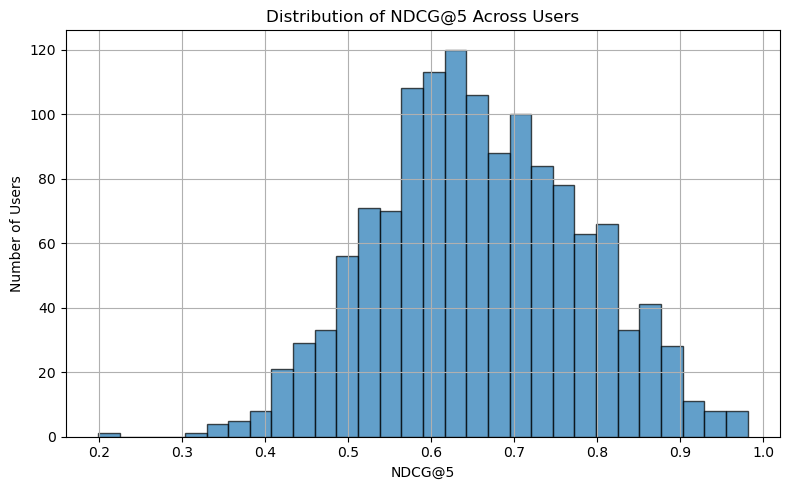

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(ndcg_5_list, bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of NDCG@5 Across Users')
plt.xlabel('NDCG@5')
plt.ylabel('Number of Users')
plt.grid(True)
plt.tight_layout()
plt.show()